In [1]:
import pandas as pds, numpy as np, tensorflow as tf
import nltk, itertools
import matplotlib.pyplot as plt

# Define methods:

In [2]:
#ensures the dataframe is 50% legit 50% phish:
def get5050(df):
    nPhish = len(df[df['label']==1])
    nLegit = len(df[df['label']==0])
    
    nMin = min(nPhish, nLegit)
    #select the nMin phish-rows
    sPhish = df[df['label']==1].sample(n=nMin)
    #select the nMin legit-rows
    sLegit = df[df['label']==0].sample(n=nMin)
    
    if(len(sPhish)!=len(sLegit)):
        print("Error laoding 50/50 dataset")
        
    return sLegit.append(sPhish,ignore_index=True)

In [3]:
def proc_urls(df, splitter):    
    if(not isinstance(splitter,nltk.tokenize.regexp.RegexpTokenizer)):
        raise TypeError("splitter of proc_url must be nltk RegexpTokenizer")
    
    if(procURL==False):
        return df
    
    newUrls = []
    for url in df["url"]:
        url = str(url).lower()

        url.encode('utf-8', 'ignore').decode()
        urlSplit = [clean.strip() for clean in splitter.tokenize(url) if(clean.strip()!="")]
    
        newUrls += " ".join(urlSplit)
    df["url"] = newUrls
    return df

In [4]:
#newUrls = []
#demourl = "komix.fandom.com/el/wiki/%CE%95%CF%80%CE%B9%CE%B8%CE%B5%CF%89%CF%81%CE%B7%CF%84%CE%AE%CF%82_%CE%9F%27%CE%A7%CE%AC%CF%81%CE%B1?diff=87300&oldid=32428"
#demourl = str(demourl).lower()
#demourl.encode('utf-8', 'ignore').decode()
#demosplitter = nltk.RegexpTokenizer("\d+|[a-z]+|\W")
#urlSplit = [clean.strip() for clean in demosplitter.tokenize(demourl) if(clean.strip()!="")]
#newUrls += " ".join(urlSplit)

In [5]:
def plot_confusion_matrix(cm, class_names, cTitle='Confusion Matrix'):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    NOTE: Modified from output of scikit learn!  
    EXPECTS: [[tp, fp],[fn,tn]]
    
    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
  
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(cTitle)
    #plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    #Normalize the confusion matrix.
    #cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    colm = np.array([["white","black"],["black","white"]])
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=colm[i,j])

    plt.tight_layout()
    plt.ylabel('Predicted')
    plt.xlabel('Truth')
  
    return figure

# Lets create our own pipeline for fine tuning:

### Do the setup for the model:

In [6]:
import transformers
from transformers import BertTokenizer, ElectraTokenizerFast, RobertaTokenizerFast, TFElectraForSequenceClassification, TFBertForSequenceClassification, TFRobertaForSequenceClassification, TFTrainer, TFTrainingArguments

checkpoint = "bert-base-uncased" #this is the checkpoint (pretrained model) we are using for the example.
tokenizer = BertTokenizer.from_pretrained(checkpoint) #setup the tokenizer. We need to pass it the checkpoint because hf models need a specific mapping of word-ids

# Let's create/load a CSV into a dataset object:

In [7]:
from sklearn.model_selection import train_test_split

#load the csv:
dfTrain = pds.read_csv("../proj/data/compiled/allTrainOrigin.csv", index_col = 0) # small set 413
dfTest = pds.read_csv("../proj/data/compiled/allTestOrigin.csv", index_col = 0) # small set 75
dfLegit = dfTrain[dfTrain["label"]==0] # small 200
dfPhish = dfTrain[dfTrain["label"]==1] # small 213
dfTrainFixed = get5050(dfTrain) # ensure phishing and legit data ratio 1:1
dfTestFixed = get5050(dfTest)
#dfTrainFixed["url"]

In [8]:
splitter = nltk.RegexpTokenizer("\d+|[a-z]+|\W")
procURL = False
dfTrainFixed = proc_urls(dfTrainFixed,splitter)
dfTestFixed = proc_urls(dfTestFixed,splitter)

display((len(dfTrainFixed), len(dfTrain)))
display((len(dfTestFixed), len(dfTest)))

(24310, 60775)

(6078, 15195)

In [9]:
dfTrainFixed

,label,url
0,0,www.dinnercheque.nl/dinnercheque-restaurants/z...
1,0,gogreydog.com/careers/human-resources
2,0,suresuta.jp/archives/83870
3,0,speakerdeck.com/brenoferreira/remote-work
4,0,www.yourwdwstore.net/Disney-Countdown-To-Chris...
...,...,...
395,1,my-halifax-uk.com/
396,1,theuniversityoftomorrow.org/images/gallery/use...
397,1,www.lightlink.com.cn/sites/default/files/2017-...
398,1,battlepubgmobile.com/


In [9]:
x = list(dfTrainFixed["url"])
y = list(dfTrainFixed["label"])

#X_train, X_val, y_train, y_val
xTR, xVA, yTR, yVA = train_test_split(x,y, shuffle=True, test_size=0.2) # shuffle all train and test data, 20% be test

320

### Tokenize:

In [10]:
tEncoding = tokenizer(xTR, truncation=True, padding=True) # tokenizer -> inputs, including token_ids and attention mask
vEncoding = tokenizer(xVA, truncation=True, padding=True)

In [11]:
len(tEncoding['input_ids'])

19448

In [12]:
trainDS = tf.data.Dataset.from_tensor_slices((dict(tEncoding),yTR))
valDS = tf.data.Dataset.from_tensor_slices((dict(vEncoding),yVA))

2021-11-04 21:45:04.919747: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [62]:
trainDS

<TensorSliceDataset shapes: ({input_ids: (512,), token_type_ids: (512,), attention_mask: (512,)}, ()), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

# Lets do some Training!

In [13]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support( \
                           labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [15]:
#OUTPUT_DIR="/s/fir/e/nobackup/Fresh-Phish/transformer_exps/progs/Trained Models"
OUTPUT_DIR="../proj/progs/TrainedModels"
training_args = TFTrainingArguments(output_dir=OUTPUT_DIR,            # output directory
            evaluation_strategy="steps",      # evaluation strategy
            num_train_epochs=3,               # total number of training epochs
            per_device_train_batch_size=16,  # batch size per device during training
            per_device_eval_batch_size=16,   # batch size for evaluation
            per_gpu_train_batch_size=16,
            per_gpu_eval_batch_size=16,
            warmup_steps=10000,  # number of warmup steps for learning rate scheduler
            weight_decay=0.01,   # strength of weight decay
            learning_rate=8.e-5, # Adam learning rate
            adam_epsilon=1.e-6)  # Adam epsilon



In [58]:
training_args.strategy.scope()

In [16]:
with training_args.strategy.scope():
    model = TFBertForSequenceClassification.from_pretrained(
            "bert-base-uncased")
    
trainer = TFTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=trainDS,               # training dataset
    eval_dataset=valDS,                  # evaluation dataset
    compute_metrics=compute_metrics      # evaluation metrics
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/proj/lib/python3.7/site-packages/transformers/trainer_tf.py:114: FutureWarning: The class `TFTrainer` is deprecated and will be removed in version 5 of Transformers. We recommend using native Keras instead, by calling methods like `fit()` and `predict()` directly on the model object. Detailed examples of the Keras style can be found in our examples at https://github.com/huggingface/transformers/tree/master/examples/tensorflow
  FutureWarning,


In [ ]:
import time
start = time.time()
trainer.train() # train.fit
stop = time.time()
print("Fine-Tuning Time: {:.2f}".format(stop-start))

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
2021-11-04 21:46:49.728917: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_4"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
input: "Placeholder/_3"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 512
        }
      }
      shape {
        dim {
          size: 512
        }
      }
      shape {
        dim {
          size: 512
        }
      }
      shape {
      }
    }
  }
}

2021-11-04 2

# Let's get the results:

In [18]:
model_result = trainer.evaluate()
print("Accuracy: {}".format(model_result['eval_accuracy']))

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
2021-10-27 10:51:31.439565: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_4"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
input: "Placeholder/_3"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 410
        }
      }
      shape {
        dim {
     

Accuracy: 0.4375


In [ ]:
model_result


### Looks good. Lets predict:

In [20]:
xTE = list(dfTestFixed["url"])
yTE = list(dfTestFixed["label"])
#create the test dataset:

testEncoding = tokenizer(xTE,truncation=True, padding=True)
testDS=tf.data.Dataset.from_tensor_slices((dict(testEncoding), yTE))

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
2021-10-27 11:12:24.902033: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_4"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
input: "Placeholder/_3"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 409
        }
      }
      shape {
        dim {
     

Training Bal Accuracy: 50.000%


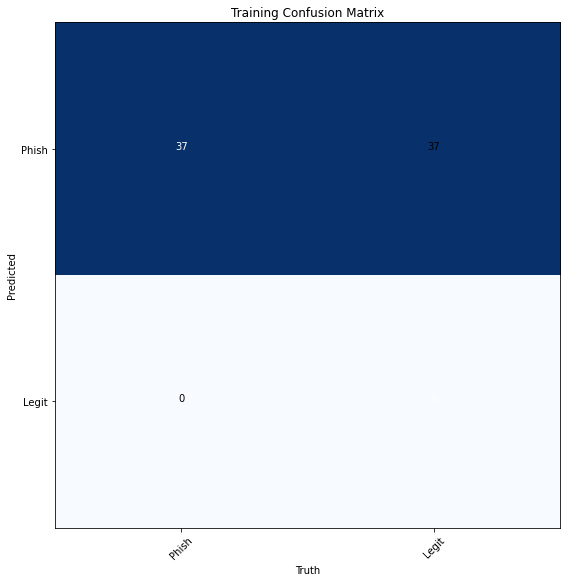

In [21]:
pred_train = trainer.predict(testDS)
trlabels = pred_train.label_ids
trpreds = pred_train.predictions.argmax(-1)


tn, fp, fn, tp = confusion_matrix(trlabels, trpreds).ravel()
traccuracy = (tp + tn)/(tn + tp + fn + fp)
traccuracyB = ((tp/(tp+fn) + tn/(fp+tn))*0.5)
print("Training Bal Accuracy: {:.3f}%".format(traccuracyB*100.))
cmatrix = np.array([[tp, fp],[fn, tn]])
disp = plot_confusion_matrix(cmatrix, ['Phish','Legit'], cTitle='Training Confusion Matrix')